# Scalability and Processing Time
C. Heiser, 2019

---
__The purpose of this notebook is to evaluate the scalability and processing time of our structural preservation metrics. A dataset from the [UMAP _Nat. Biotech._ paper (Becht, _et al._ 2018)](https://www.nature.com/articles/nbt.4314) is evaluated:__

Mouse Cell Atlas Hematopoeitic Dataset [GSE108097](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE108097)

In [1]:
import sys
sys.path.append('../')
from fcc_utils import *

In [2]:
# ignore numba deprecation warnings given by sc.pp.neighbors()
import numba
import warnings
warnings.simplefilter('ignore', numba.errors.NumbaWarning)
warnings.simplefilter('ignore', numba.errors.NumbaDeprecationWarning)
warnings.simplefilter('ignore', numba.errors.NumbaPerformanceWarning)

In [3]:
%time hemato = sc.read('../inputs/mca_hemato.h5ad') # read in MCA hemato scRNA-seq data

CPU times: user 11.5 s, sys: 2.05 s, total: 13.6 s
Wall time: 13.5 s


---
### Downsample `Obs` and `Var`
Our dataset has __>45k cells__ and __>25k gene features__.

Let's downsample to __10k cells__ and perform a __500-component PCA__ to serve as _native space_ (input to downstream dimension-reduction method(s)).

In [ ]:
sc.pp.subsample(data=hemato, n_obs=10000, random_state=18) # random sample of 10k cells inplace
hemato

Perform standard preprocessing of `AnnData` object:

In [4]:
%%time
# raw
hemato.layers['raw_counts'] = hemato.X.copy() # store raw counts before manipulation
# obs/var
hemato.var['mito'] = hemato.var_names.str.contains('mt-') # identify mitochondrial genes
sc.pp.calculate_qc_metrics(hemato, qc_vars=['mito'], inplace=True) # calculate standard qc .obs and .var
# normalize/transform
sc.pp.normalize_total(hemato, target_sum=10000, layers=None, layer_norm=None, key_added='norm_factor')
sc.pp.log1p(hemato) # log1p transform counts
# HVGs
sc.pp.highly_variable_genes(hemato, flavor='seurat', n_top_genes=2000)

CPU times: user 21.1 s, sys: 4.43 s, total: 25.5 s
Wall time: 25.6 s


In [5]:
%%time
sc.pp.scale(hemato, max_value=10)
sc.tl.pca(hemato, use_highly_variable=False, n_comps=100)

CPU times: user 3min 10s, sys: 9.06 s, total: 3min 19s
Wall time: 41.1 s


In [6]:
# create neighborhood graphs from PCA results and perform louvain clustering
# heads-up: you will get a numba deprecation warning the first time you run this
sc.pp.neighbors(hemato, n_neighbors=210, use_rep='X_pca', n_pcs=100, knn=True, random_state=18, metric='euclidean', copy=False)
sc.tl.louvain(hemato, resolution=1.0, key_added='louvain', random_state=18, copy=False)
hemato.obs['clusterID'] = 'cluster_' + hemato.obs['louvain'].astype(str)

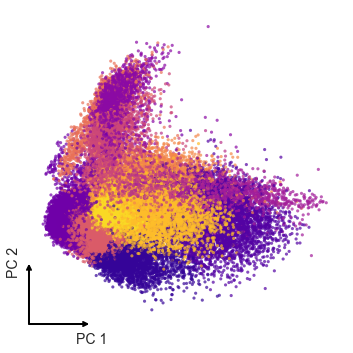

In [10]:
DR_plot(dim_name='PC').plot_IDs(hemato, use_rep='X_pca', obs_col='clusterID', pt_size=10)

Calculating unique distances for native space, X
Calculating unique distances for latent space, X_pca
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
k-nearest neighbor calculation for native space, X
k-nearest neighbor calculation for latent space, X_pca
Determining nearest neighbor preservation

Done!
R: 0.7352
EMD: 0.158
Knn %: 94.3673


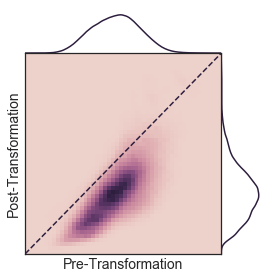

In [15]:
%%time
hemato_1k = sc.pp.subsample(data=hemato, n_obs=1000, random_state=18, copy=True)
corr, EMD, knnP = structure_preservation_sc(hemato_1k, latent='X_pca', native='X', k=30) # 1000 cells
print('R: {}\nEMD: {}\nKnn %: {}'.format(round(corr[0],4), round(EMD,4), round(knnP,4)))
joint_plot_distance_correlation(hemato_1k.uns['X_norm_distances'], hemato_1k.uns['X_pca_norm_distances'])

Calculating unique distances for native space, X
Calculating unique distances for latent space, X_pca
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
k-nearest neighbor calculation for native space, X
k-nearest neighbor calculation for latent space, X_pca
Determining nearest neighbor preservation

Done!
R: 0.7423
EMD: 0.1538
Knn %: 97.1517


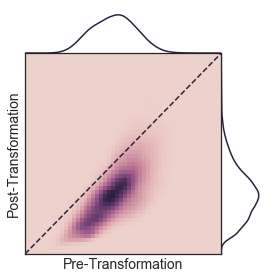

In [16]:
%%time
hemato_2k = sc.pp.subsample(data=hemato, n_obs=2000, random_state=18, copy=True)
corr, EMD, knnP = structure_preservation_sc(hemato_2k, latent='X_pca', native='X', k=30) # 2000 cells
print('R: {}\nEMD: {}\nKnn %: {}'.format(round(corr[0],4), round(EMD,4), round(knnP,4)))
joint_plot_distance_correlation(hemato_2k.uns['X_norm_distances'], hemato_2k.uns['X_pca_norm_distances'])

Calculating unique distances for native space, X
Calculating unique distances for latent space, X_pca
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
k-nearest neighbor calculation for native space, X
k-nearest neighbor calculation for latent space, X_pca
Determining nearest neighbor preservation

Done!
R: 0.7449
EMD: 0.1882
Knn %: 98.5617


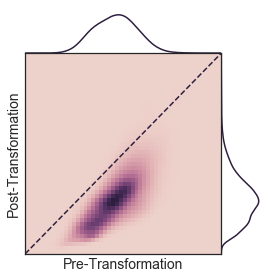

In [17]:
%%time
hemato_4k = sc.pp.subsample(data=hemato, n_obs=4000, random_state=18, copy=True)
corr, EMD, knnP = structure_preservation_sc(hemato_4k, latent='X_pca', native='X', k=30) # 4000 cells
print('R: {}\nEMD: {}\nKnn %: {}'.format(round(corr[0],4), round(EMD,4), round(knnP,4)))
joint_plot_distance_correlation(hemato_4k.uns['X_norm_distances'], hemato_4k.uns['X_pca_norm_distances'])

Calculating unique distances for native space, X
Calculating unique distances for latent space, X_pca
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
k-nearest neighbor calculation for native space, X
k-nearest neighbor calculation for latent space, X_pca
Determining nearest neighbor preservation

Done!
R: 0.7423
EMD: 0.2194
Knn %: 99.0385


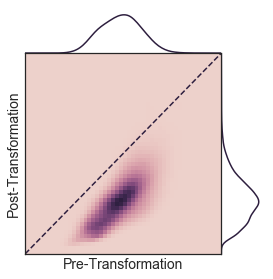

In [18]:
%%time
hemato_6k = sc.pp.subsample(data=hemato, n_obs=6000, random_state=18, copy=True)
corr, EMD, knnP = structure_preservation_sc(hemato_6k, latent='X_pca', native='X', k=30) # 6000 cells
print('R: {}\nEMD: {}\nKnn %: {}'.format(round(corr[0],4), round(EMD,4), round(knnP,4)))
joint_plot_distance_correlation(hemato_6k.uns['X_norm_distances'], hemato_6k.uns['X_pca_norm_distances'])

Calculating unique distances for native space, X
Calculating unique distances for latent space, X_pca
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
k-nearest neighbor calculation for native space, X
k-nearest neighbor calculation for latent space, X_pca
Determining nearest neighbor preservation

Done!
R: 0.7466
EMD: 0.2139
Knn %: 99.2781
CPU times: user 15min 10s, sys: 7.85 s, total: 15min 18s
Wall time: 14min 26s


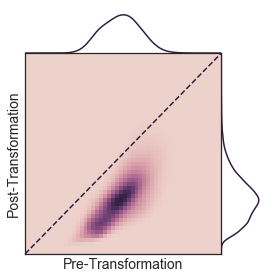

In [19]:
%%time
hemato_8k = sc.pp.subsample(data=hemato, n_obs=8000, random_state=18, copy=True)
corr, EMD, knnP = structure_preservation_sc(hemato_8k, latent='X_pca', native='X', k=30) # 8000 cells
print('R: {}\nEMD: {}\nKnn %: {}'.format(round(corr[0],4), round(EMD,4), round(knnP,4)))
joint_plot_distance_correlation(hemato_8k.uns['X_norm_distances'], hemato_8k.uns['X_pca_norm_distances'])

Calculating unique distances for native space, X
Calculating unique distances for latent space, X_pca
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
k-nearest neighbor calculation for native space, X
k-nearest neighbor calculation for latent space, X_pca
Determining nearest neighbor preservation

Done!
R: 0.7457
EMD: 0.2169
Knn %: 99.4221
CPU times: user 24min 21s, sys: 7.85 s, total: 24min 29s
Wall time: 24min 30s


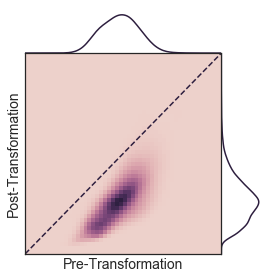

In [20]:
%%time
hemato_10k = sc.pp.subsample(data=hemato, n_obs=10000, random_state=18, copy=True)
corr, EMD, knnP = structure_preservation_sc(hemato_10k, latent='X_pca', native='X', k=30) # 10000 cells
print('R: {}\nEMD: {}\nKnn %: {}'.format(round(corr[0],4), round(EMD,4), round(knnP,4)))
joint_plot_distance_correlation(hemato_10k.uns['X_norm_distances'], hemato_10k.uns['X_pca_norm_distances'])

In [21]:
time_1k = %timeit -n 3 -r 3 -o structure_preservation_sc(hemato_1k, latent='X_pca', native='X', k=30) # 1000 cells

Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
Correlating distances
Normalizing unique distances
Calcula

In [22]:
time_2k = %timeit -n 3 -r 3 -o structure_preservation_sc(hemato_2k, latent='X_pca', native='X', k=30) # 2000 cells

Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
Correlating distances
Normalizing unique distances
Calcula

In [23]:
time_4k = %timeit -n 3 -r 3 -o structure_preservation_sc(hemato_4k, latent='X_pca', native='X', k=30) # 4000 cells

Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
Correlating distances
Normalizing unique distances
Calcula

In [24]:
time_6k = %timeit -n 3 -r 3 -o structure_preservation_sc(hemato_6k, latent='X_pca', native='X', k=30) # 6000 cells

Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
Correlating distances
Normalizing unique distances
Calcula

In [25]:
time_8k = %timeit -n 3 -r 3 -o structure_preservation_sc(hemato_8k, latent='X_pca', native='X', k=30) # 8000 cells

Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
Correlating distances
Normalizing unique distances
Calcula

In [26]:
time_10k = %timeit -n 3 -r 3 -o structure_preservation_sc(hemato_10k, latent='X_pca', native='X', k=30) # 10000 cells

Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
Determining nearest neighbor preservation

Done!
Correlating distances
Normalizing unique distances
Calcula

In [27]:
final = pd.DataFrame(np.stack([np.append(np.array(time_1k.all_runs)/time_1k.loops, [time_1k.average, time_1k.stdev]),
                               np.append(np.array(time_2k.all_runs)/time_2k.loops, [time_2k.average, time_2k.stdev]),
                               np.append(np.array(time_4k.all_runs)/time_4k.loops, [time_4k.average, time_4k.stdev]),
                               np.append(np.array(time_6k.all_runs)/time_6k.loops, [time_6k.average, time_6k.stdev]),
                               np.append(np.array(time_8k.all_runs)/time_8k.loops, [time_8k.average, time_8k.stdev]),
                               np.append(np.array(time_10k.all_runs)/time_10k.loops, [time_10k.average, time_10k.stdev])]
                             ), 
                     columns=['rep1','rep2','rep3','avg','sd']
                    )
final['n'] = [1000,2000,4000,6000,8000,10000]

In [51]:
final.to_csv('outputs/time.csv', index=False)

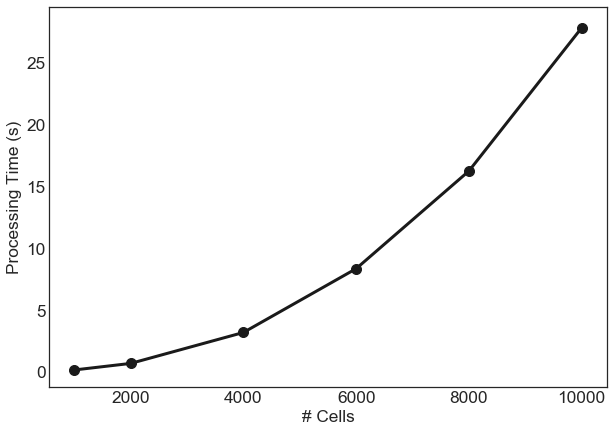

In [50]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10,7))
    plt.errorbar('n', 'avg', 'sd', data=final, linewidth=3, fmt='ko-', markersize=10)
    plt.xlabel('# Cells', fontsize='xx-large')
    plt.ylabel('Processing Time (s)', fontsize='xx-large')
    plt.xticks(fontsize='xx-large')
    plt.yticks(fontsize='xx-large')
    plt.savefig('outputs/time.png', dpi=1000)